In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import copy

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved waveforms

In [4]:
# trainset = ws.HDF5WaveformSet('../data/dh_training_set.hdf5')
# testset_rand = ws.HDF5WaveformSet('../data/dh_test_set_rand.hdf5')
# testset_uni = ws.HDF5WaveformSet('../data/dh_test_set_uniform.hdf5')

trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015.hdf5')
#trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015_n1056.hdf5')
len(trainset)

160

In [5]:
# params_rand = testset_rand.parameters()
# limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
# #kernel_type = 'matern52'

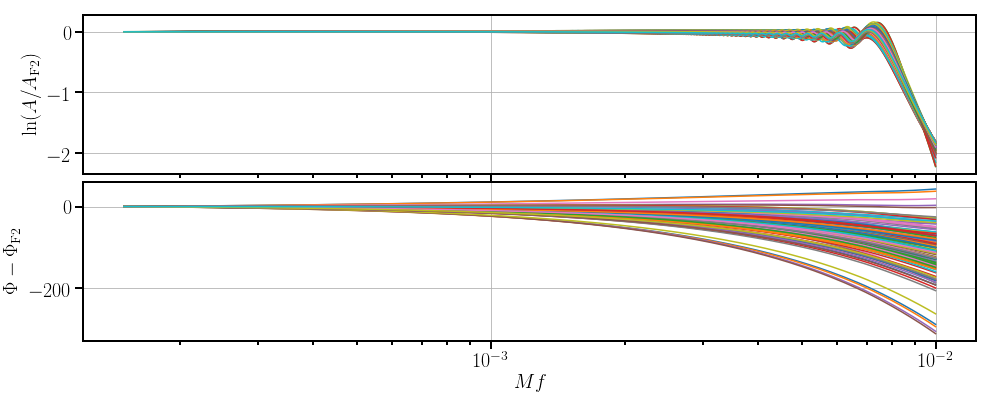

In [6]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Load surrogate model as well as the interpolating functions of (mf, params)

In [7]:
Bamp_filename = '../data/Bamp_p00015.hdf5'
Bphase_filename = '../data/Bphase_p00015.hdf5'
damp_gp_filename = '../data/amp_gp_p00015.hdf5'
dphase_gp_filename = '../data/phase_gp_p00015.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

# Bamp_filename = '../data/Bamp_p00015_n1056.hdf5'
# Bphase_filename = '../data/Bphase_p00015_n1056.hdf5'
# damp_gp_filename = '../data/amp_gp_p00015_n1056.hdf5'
# dphase_gp_filename = '../data/phase_gp_p00015_n1056.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

Bamp = ws.HDF5WaveformSet(Bamp_filename)
Bphase = ws.HDF5WaveformSet(Bphase_filename)
damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)

limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])

In [8]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')

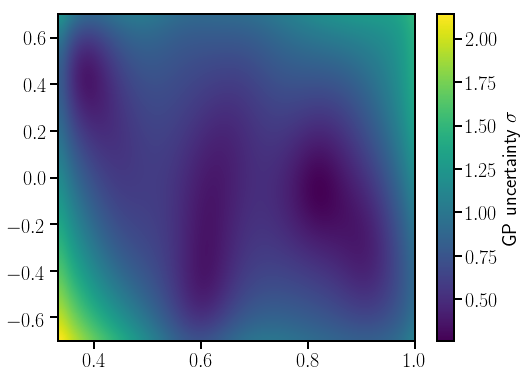

In [9]:
# print maximum_error(func, gp, limits, error_type='absolute', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional_full_range', nsample=100000)

x0, x1, x2, x3, x4 = 0.8, -0.5, 0.4, 5000.0, 5000.0
def gp_predict_error(x0, x1):
    i = 19
    return dphase_gp_list[i].predict(np.array([[x0, x1, x2, x3, x4]]), return_std=True)[1][0]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
#plot_numbered_points(ax1, points)

0.00329528293287


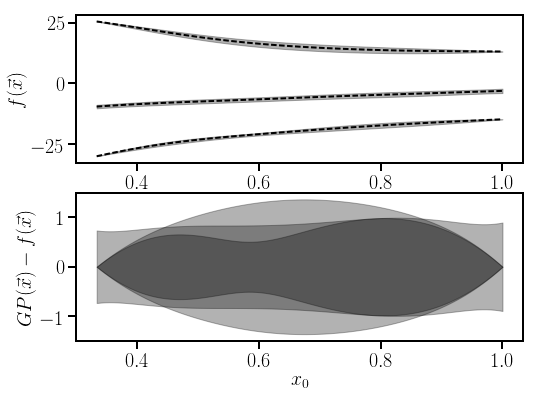

In [10]:
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0.0, 0.0
i = 2
mf = Bphase.get_waveform(i, data='parameters')[0]
print mf
gp = dphase_gp_list[i]

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(-0.7, 0.7, 3):
    x0s = np.linspace(1.0/3.0, 1.0, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(x0s, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(x0s, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    #ax[1].plot(x0s, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(x0s, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
# ax[0].legend(bbox_to_anchor=(1.25, 1.05))
# ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Uncertainty sampling

In [11]:
def trapezoid_rule(xs, ys):
    """Use trapezoid rule to integrate between [xs[0], xs[-1]].
    xs don't have to be evenly spaced.
    """
    dxs = xs[1:] - xs[:-1]
    return np.sum(0.5*(ys[:-1]+ys[1:])*dxs)

In [12]:
def objective_function(point, dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, mfs_amp, mfs_phase, mf_0):
    """Objective function to minimize when searching for new training set points.
    This function provides an estimate of the error.
    Currently using the distinguishability with whitened psd.
    
    Parameters
    ----------
    point : n-d array
        Point x in parameter space to evaluate.
    dlnamp_gp_list :
        List of GPR functions for evaluating Deltaln(A(F_j; x) at the empirical nodes F_j
    sigma_dlnamp_gp_list :
        List of GPR functions for evaluating sigma_Deltaln(A).
        This is not the same as dlnamp_gp_list, because it gets updated, and the data can be anything.
    sigma_dphase_gp_list :
        List of GPR functions for evaluating sigma_DeltaPhi.
    mfs_amp : array
        Frequencies MF_j for the amplitude empirical nodes.
    mfs_phase : array
        Frequencies for the phase empirical nodes.
    mf_0 : Starting frequency where DeltaPhi is 0 (!!! but Deltaln(A) is not !!! This is a slight error.)
    """
    
    namp = len(sigma_dlnamp_gp_list)
    nphase = len(sigma_dphase_gp_list)
    
    # Calculate waveform at nodes
    dlnamp = np.array([dlnamp_gp_list[j].predict(np.atleast_2d(point), return_std=False)[0] 
                             for j in range(namp)])
    sigma_dlnamp = np.array([sigma_dlnamp_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                             for j in range(namp)])
    sigma_dphase = np.array([sigma_dphase_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                               for j in range(nphase)])
    
    integrand_amp = sigma_dlnamp**2 * mfs_amp**(-7.0/3.0) * np.exp(2.0*dlnamp)
    integrand_phase = sigma_dphase**2 * mfs_phase**(-7.0/3.0) * np.exp(2.0*dlnamp)
    
    # Add the point at the beginning of the waveform when the error is zero
    mfs_amp = np.insert(mfs_amp, 0, mf_0)
    mfs_phase = np.insert(mfs_phase, 0, mf_0)
    integrand_amp = np.insert(integrand_amp, 0, 0.0)
    integrand_phase = np.insert(integrand_phase, 0, 0.0)
    dh_dot_dh = 4.0*(trapezoid_rule(mfs_amp, integrand_amp) + trapezoid_rule(mfs_phase, integrand_phase))
    return np.sqrt(dh_dot_dh)



# def objective_function(point, dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, mfs_amp, mfs_phase, mf_0):
#     """Objective function to minimize when searching for new training set points.
#     This function provides an estimate of the error.
#     Currently using the distinguishability with whitened psd.
#     """
    
#     namp = len(sigma_dlnamp_gp_list)
#     nphase = len(sigma_dphase_gp_list)
    
#     # Calculate waveform at nodes
#     sigma_dphase = np.array([sigma_dphase_gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
#                                for j in range(nphase)])
    
#     return np.sqrt(np.sum(sigma_dphase**2))

In [13]:
def sample_new_point_with_fixed_hyperparameters(
    points, limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, 
    nsamples=100):
    """Get new point using uncertainty sampling.
    The points are needed but the data is not, because the GPR uncertainty
    does not depend on the data.

    Parameters
    ----------
    points : 2d array (npoints, ndim).
        Coordinates of sampled data.
    limits : np.array([[x1_min, x1_max], [x2_min, x2_max], [x3_min, x3_max], ...])
        Boundaries of the hypercube.
    kernel_type : 'squaredexponential', 'matern32', 'matern52'
    dlnamp_gp_list :
        List of GPR functions for evaluating Deltaln(A(F_j; x) at the empirical nodes F_j
    dlnamp_hp_list : 
        Hyperparameters for dlnamp_list functions.
        Order is (sigma_f, ls_0, ls_1, ..., sigma_n).
    dlnamp_hp_list : 1d array (ndim+2,)
        Hyperparameters for dphase_list functions.
        mfs_amp : array
        Frequencies MF_j for the amplitude empirical nodes.
    mfs_phase : array
        Frequencies for the phase empirical nodes.
    mf_0 : Starting frequency where DeltaPhi is 0 (!!! but Deltaln(A) is not !!! This is a slight error.)     
    nsamples : int
        number of random points to search for largest GPR uncertainty.

    Returns
    -------
    point_new : The new point
    err_new : Estimate of the error at the new point.
        This should be ~max error over the parameter space.
    """
    namp = len(dlnamp_hp_list)
    nphase = len(dphase_hp_list)
    
    # Make fake data
    data = np.ones(len(points))

    # Generate GPR at each amplitude node
    sigma_dlnamp_gp_list = []
    for j in range(namp):
        hp = dlnamp_hp_list[j]
        gp = gpr.generate_gp(points, data, hp, fixed=True, kernel_type=kernel_type)
        sigma_dlnamp_gp_list.append(gp)
        
    # Generate GPR at each phase node
    sigma_dphase_gp_list = []
    for j in range(nphase):
        hp = dphase_hp_list[j]
        gp = gpr.generate_gp(points, data, hp, fixed=True, kernel_type=kernel_type)
        sigma_dphase_gp_list.append(gp)
        
    # ******* Perform uncertainty sampling *******
    
    # --Find the point with the maximum uncertainty given the current Gaussian process.
    # --For now use Monte Carlo sampling.
    # --Later, do a multistart optimization.
    test_points = doe.uniform_random_samples(nsamples, limits)
    
    test_errs = np.array([objective_function(
        p, 
        dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, 
        mfs_amp, mfs_phase, mf_0) for p in test_points])
    
    i_max = np.argmax(test_errs)
    point_new = test_points[i_max]
    err_new = test_errs[i_max]
    
    #print err_new, test_errs
    return point_new, err_new

In [37]:
def sample_n_new_points_with_fixed_hyperparameters(
    n_new, points, 
    limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, nsamples=100):
    """Get n_new new points.
    """
    points_updated = copy.copy(points)
    error_list = []
    for i in range(n_new):
        print i,
        # Find the best location for the new point
        point_new, error_new = sample_new_point_with_fixed_hyperparameters(
            points_updated, 
            limits, kernel_type, 
            dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
            mfs_amp, mfs_phase, mf_0, nsamples=nsamples)

        # Add the new point to the list of updated points
        points_updated = np.concatenate((points_updated, np.atleast_2d(point_new)))
        error_list.append(error_new)
    # Return just the new points that you added
    return points_updated[-n_new:], np.array(error_list)

In [20]:
point = np.array([0.8, 0.3, 0.7, 3455, 2579])
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.00015

print objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

%timeit objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

55.7639729536
10 loops, best of 3: 27.1 ms per loop


In [ ]:
# def mismatch_error(point):
#     return objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

# x0 = np.array([0.6, 0.1, 0.2, 4000., 4000.])
# optimize.basinhopping(
#     mismatch_error, x0, niter=10, T=1.0, stepsize=0.5, 
#     minimizer_kwargs=None, take_step=None, accept_test=None, 
#     callback=None, interval=50, disp=False, niter_success=None)

In [32]:
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.00015
nsamples=200

In [36]:
point_new, err_new = sample_new_point_with_fixed_hyperparameters(
    points, limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, 
    nsamples=nsamples)

point_new, err_new

(array([  8.69749415e-01,   6.19370102e-01,   5.77102210e-01,
          9.72654046e+03,   8.98894496e+03]), 95.643883791594106)

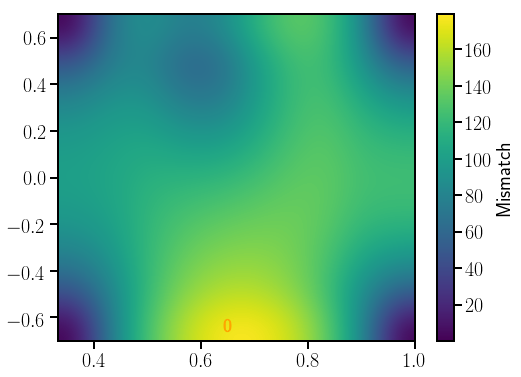

In [29]:
#x0, x1, x2, x3, x4 = 0.8, -0.5, 0.4, 5000.0, 5000.0
# x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'Mismatch')
plot_numbered_points(ax1, np.array([point_new]))

In [51]:
n_new = 100
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.00015
nsamples=1000

points_new, errors_new = sample_n_new_points_with_fixed_hyperparameters(
    n_new, points, 
    limits, kernel_type, 
    dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
    mfs_amp, mfs_phase, mf_0, nsamples=nsamples)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


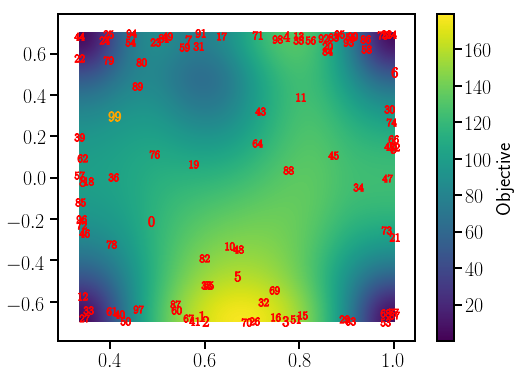

In [54]:
#x0, x1, x2, x3, x4 = 0.8, -0.5, 0.4, 5000.0, 5000.0
# x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'Objective')
plot_numbered_points(ax1, points_new)

(0, 150)

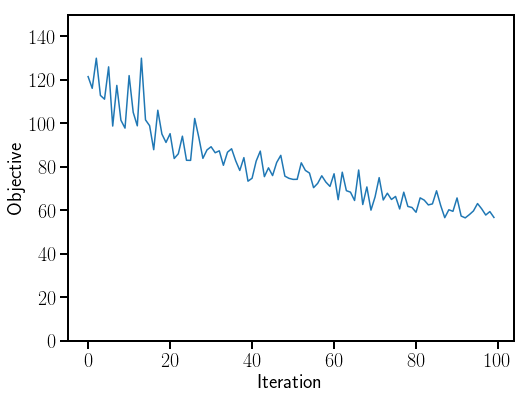

In [56]:
fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(errors_new)
axes.set_xlabel('Iteration')
axes.set_ylabel('Objective')
axes.set_ylim(0, 150)

In [62]:
points_errors = np.concatenate((points_new.T, np.array([errors_new]))).T
points_errors[:5, [0,5]]

array([[   0.48525642,  121.53123962],
       [   0.59216956,  116.14894703],
       [   0.60140127,  129.99939799],
       [   0.76939918,  112.89149566],
       [   0.77135144,  111.15893486]])

In [63]:
np.savetxt('../data/new_points_errors.txt', points_errors)

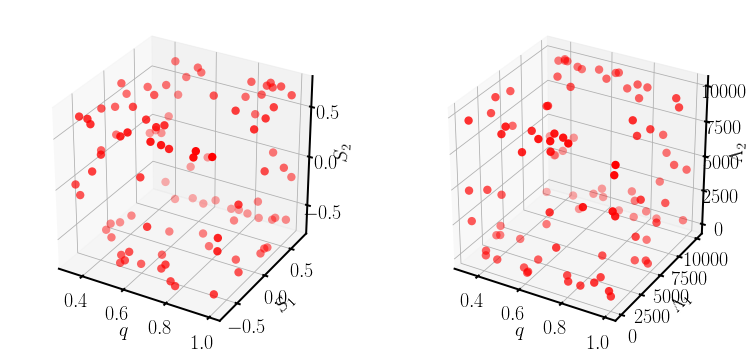

In [64]:
fig = plt.figure(figsize=(13, 6))

axes = fig.add_subplot(121, projection='3d')
params = points_new
x, y, z = params[:, 0], params[:, 1], params[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$S_2$')

axes = fig.add_subplot(122, projection='3d')
params = points_new
x, y, z = params[:, 0], params[:, 3], params[:, 4]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$\Lambda_1$')
axes.set_zlabel('$\Lambda_2$')

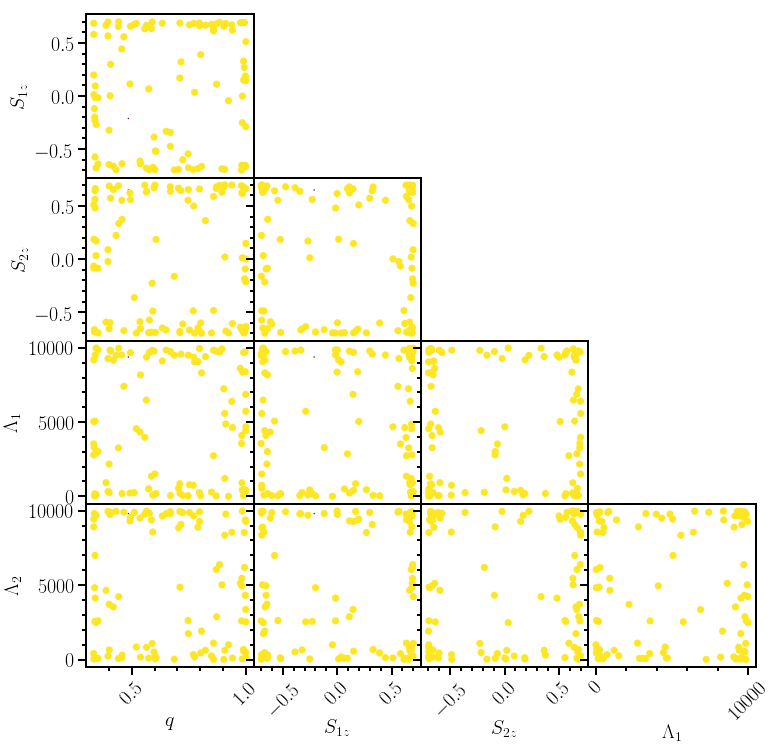

In [65]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = points_new
error = np.ones(len(params))
error[0]*=0.5
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, figsize=(10, 10))

In [68]:
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.00015


points_updated = np.concatenate((points, points_new))

namp = len(dlnamp_hp_list)
nphase = len(dphase_hp_list)

# Make fake data
data = np.ones(len(points_updated))

# Generate GPR at each amplitude node
sigma_dlnamp_gp_list = []
for j in range(namp):
    hp = dlnamp_hp_list[j]
    gp = gpr.generate_gp(points_updated, data, hp, fixed=True, kernel_type=kernel_type)
    sigma_dlnamp_gp_list.append(gp)
    
# Generate GPR at each phase node
sigma_dphase_gp_list = []
for j in range(nphase):
    hp = dphase_hp_list[j]
    gp = gpr.generate_gp(points_updated, data, hp, fixed=True, kernel_type=kernel_type)
    sigma_dphase_gp_list.append(gp)

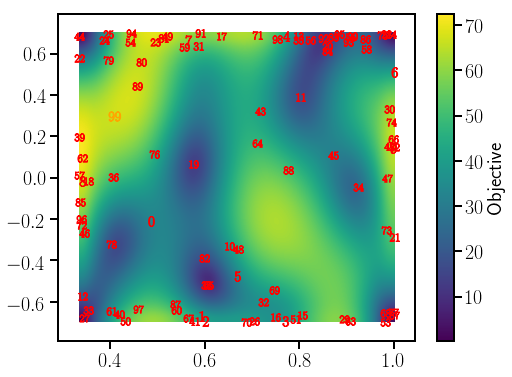

In [70]:
#x0, x1, x2, x3, x4 = 0.8, -0.5, 0.4, 5000.0, 5000.0
# x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return objective_function(point, damp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, mfs_amp, mfs_phase, mf_0)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 30
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 30
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'Objective')
plot_numbered_points(ax1, points_new)

In [19]:
import multiprocessing

def f(x, a, b, c):
    return 1000*a + 100*b + 10*c + x

# Map can only take one argument, so make a temporary function
def g(x):
    a=1; b=1; c=1
    return f(a, b, c, x)

def g(x):
    return x**2

# For some reason lambdas don't work
#a=1; b=1; c=1
#g = lambda x: f(a, b, c, x)

ncpu = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=ncpu)
#pool = multiprocessing.Pool()
print ncpu

glist = pool.map(g, range(11))
print glist

8
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


In [20]:
import multiprocessing

test_points = doe.uniform_random_samples(nsamples, limits)

obj_params = [
    (test_points[i], 
    damp_gp_list, damp_gp_list, dphase_gp_list, 
    mfs_amp, mfs_phase, mf_0) 
    for i in range(len(test_points))]

def objective_function_wrapper(obj_params):
    return objective_function(*obj_params)

In [21]:
objective_function_wrapper(obj_params[0])

50.910600407909449

In [22]:
len(obj_params)

10

In [ ]:
ncpu = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=ncpu)
#pool = multiprocessing.Pool()
print ncpu

pool.map(objective_function_wrapper, obj_params)

8


In [1]:
from multiprocessing import Process

def f(name):
    print 'hello', name

p = Process(target=f, args=('bob',))
p.start()
p.join()

hello bob


In [123]:
p0 = doe.uniform_random_samples(1, limits)[0]
p0

array([  3.70020773e-01,  -2.55142989e-01,  -4.83795271e-01,
         1.89950058e+03,   6.67950672e+03])

In [ ]:
def obj_for_min(params):
    return -objective_function(params, 
                               dlnamp_gp_list, sigma_dlnamp_gp_list, sigma_dphase_gp_list, 
                               mfs_amp, mfs_phase, mf_0)

res = optimize.minimize(obj_for_min, p0)

In [187]:
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.0005

pn = sample_new_point_with_fixed_hyperparameters(points, limits, kernel_type, 
                                                dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
                                                mfs_amp, mfs_phase, mf_0)

[[ 0.33333333  1.        ]
 [-0.7         0.7       ]
 [-0.7         0.7       ]
 [ 0.          1.        ]
 [ 0.          1.        ]]
[ 0.79426906  0.31466702 -0.41274055  0.91724601  0.03696775] -18.2464872377
[ 0.33333333 -0.05393215 -0.7         0.91210601  0.03143026] -32.4661968319


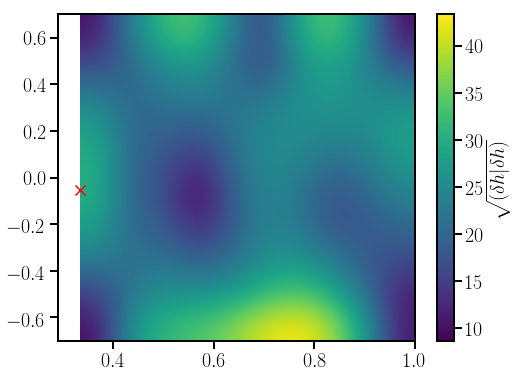

In [189]:
x0, x1, x2, x3, x4 = pn
def gp_predict_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return objective_function(point, damp_gp_list, damp_gp_list, dphase_gp_list, mfs_amp, mfs_phase, mf_0)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$\sqrt{(\delta h | \delta h)}$')
ax1.scatter(x0, x1, marker='x', s=100, color='r')
#plot_numbered_points(ax1, points)

In [ ]:
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.0005
nsamples=100

In [114]:
point_new, test_points, test_errs = sample_new_point_with_fixed_hyperparameters(points, limits, kernel_type, 
                                                dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
                                                mfs_amp, mfs_phase, mf_0, 
                                                nsamples=nsamples)

In [115]:
test_errs

array([ 10.14089483,  10.73899975,   9.74898918,  10.87931977,
         6.74501966,  10.7971101 ,   9.3790129 ,   7.51391883,
        10.73973353,   5.93382053,  12.83307732,   3.82902723,
         5.9225888 ,  23.3065328 ,  13.99284847,   9.54789901,
         3.50208628,  13.79008663,  15.12447182,  15.72333048,
        10.65052677,  14.41757175,  15.2309122 ,   7.49894937,
        14.9399456 ,   9.27724691,   8.78912717,  13.38375944,
        11.84642165,  12.98146122,   5.62410283,  12.32606177,
         5.2824546 ,  14.58273042,  10.34901795,  13.81566171,
         5.91643676,   7.38483136,   9.1269904 ,   9.55174435,
         8.98304339,   9.15588379,   5.2765578 ,   4.7921179 ,
        20.29165305,  17.41322743,   7.80205975,   8.51340628,
         7.98300667,  19.43099327,  10.81261375,   9.33498034,
        16.0591891 ,   7.43601531,  12.61041724,  11.98567559,
        12.77240566,   9.14504793,  11.81979087,  14.64775696,
         5.32655338,   5.85731412,   7.35286798,  17.82

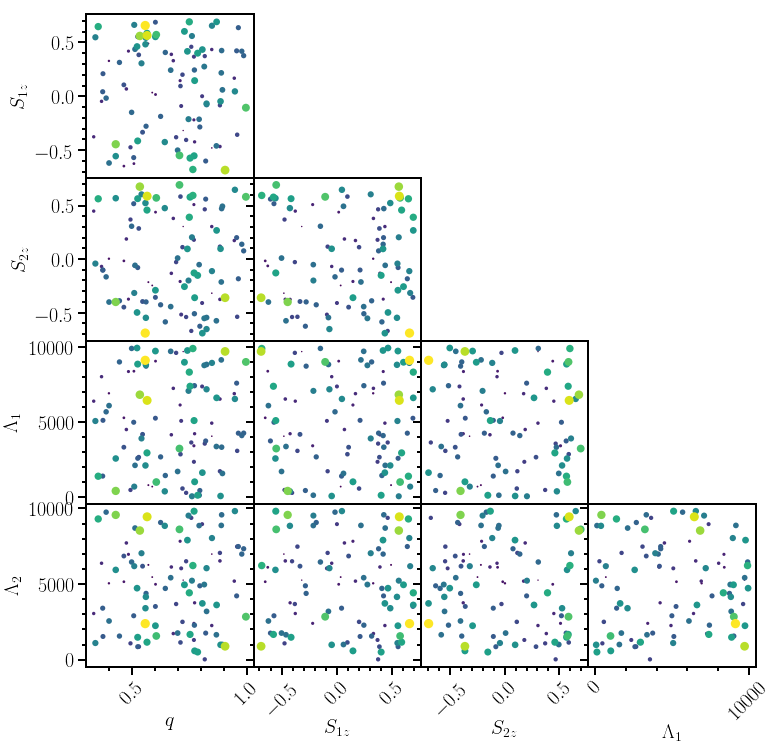

In [116]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = test_points
error = test_errs
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, figsize=(10, 10))

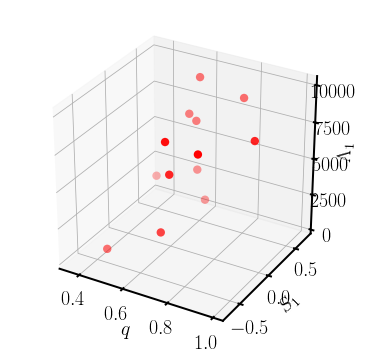

In [117]:
fig = plt.figure(figsize=(6, 6))
axes = fig.add_subplot(111, projection='3d')
params = test_points[test_errs>15.0]
x, y, z = params[:, 0], params[:, 1], params[:, 3]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$\Lambda_1$')

In [228]:
n_new = 50
points = trainset.parameters()
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'
dlnamp_gp_list = damp_gp_list
dlnamp_hp_list = [gpr.get_hyperparameters(gp) for gp in damp_gp_list]
dphase_hp_list = [gpr.get_hyperparameters(gp) for gp in dphase_gp_list]
mfs_amp = np.array([Bamp.get_waveform(j, data='parameters')[0] for j in range(len(Bamp))])
mfs_phase = np.array([Bphase.get_waveform(j, data='parameters')[0] for j in range(len(Bphase))])
mf_0 = 0.0005

points_new, fmin = sample_n_new_points_with_fixed_hyperparameters(n_new, points, 
            limits, kernel_type, 
            dlnamp_gp_list, dlnamp_hp_list, dphase_hp_list, 
            mfs_amp, mfs_phase, mf_0)

0 [[ 0.33333333  1.        ]
 [-0.7         0.7       ]
 [-0.7         0.7       ]
 [ 0.          1.        ]
 [ 0.          1.        ]]
[ 0.3905735   0.55035486  0.40020643  0.51097301  0.47100596] -9.80035905474
[ 0.33333333  0.7         0.7         0.42887685  1.        ] -38.9264119128
1 [[ 0.33333333  1.        ]
 [-0.7         0.7       ]
 [-0.7         0.7       ]
 [ 0.          1.        ]
 [ 0.          1.        ]]
[ 0.3531903   0.41250108 -0.62834868  0.42643841  0.03670889] -18.4990105799
[ 0.33333333  0.7        -0.7         0.44406895  0.        ] -30.8063654478
2 [[ 0.33333333  1.        ]
 [-0.7         0.7       ]
 [-0.7         0.7       ]
 [ 0.          1.        ]
 [ 0.          1.        ]]
[ 0.80899845  0.67646856 -0.02835426  0.8650154   0.83643012] -15.283369946
[ 0.50159173  0.7        -0.7         1.          0.        ] -41.4770520913
3 [[ 0.33333333  1.        ]
 [-0.7         0.7       ]
 [-0.7         0.7       ]
 [ 0.          1.        ]
 [ 0.          

In [229]:
points_new

array([[  3.33333333e-01,   7.00000000e-01,   7.00000000e-01,
          4.28876850e+03,   1.00000000e+04],
       [  3.33333333e-01,   7.00000000e-01,  -7.00000000e-01,
          4.44068953e+03,   0.00000000e+00],
       [  5.01591732e-01,   7.00000000e-01,  -7.00000000e-01,
          1.00000000e+04,   0.00000000e+00],
       [  1.00000000e+00,   1.55381529e-01,   7.00000000e-01,
          0.00000000e+00,   2.94212533e+03],
       [  3.33333333e-01,   7.00000000e-01,   2.30379803e-01,
          2.90901473e+03,   0.00000000e+00],
       [  4.89648285e-01,   7.00000000e-01,   7.00000000e-01,
          3.23059317e+03,   1.00000000e+04],
       [  1.00000000e+00,  -1.36952990e-03,   7.00000000e-01,
          1.00000000e+04,   1.00000000e+04],
       [  7.27539581e-01,  -7.00000000e-01,  -7.00000000e-01,
          1.00000000e+04,   0.00000000e+00],
       [  3.33333333e-01,  -7.00000000e-01,  -7.00000000e-01,
          4.24582569e+03,   0.00000000e+00],
       [  1.00000000e+00,  -7.0000000

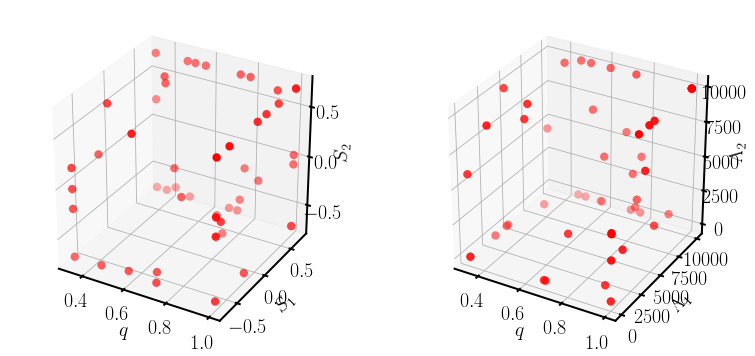

In [230]:
fig = plt.figure(figsize=(13, 6))

axes = fig.add_subplot(121, projection='3d')
params = points_new
x, y, z = params[:, 0], params[:, 1], params[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$S_1$')
axes.set_zlabel('$S_2$')

axes = fig.add_subplot(122, projection='3d')
params = points_new
x, y, z = params[:, 0], params[:, 3], params[:, 4]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)
axes.set_xlabel('$q$')
axes.set_ylabel('$\Lambda_1$')
axes.set_zlabel('$\Lambda_2$')

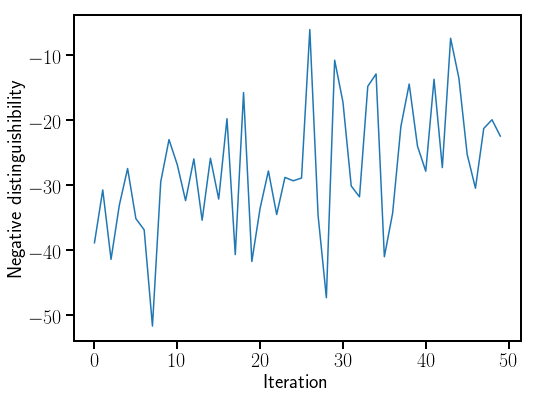

In [231]:
fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(fmin)
axes.set_xlabel('Iteration')
axes.set_ylabel('Negative distinguishibility')

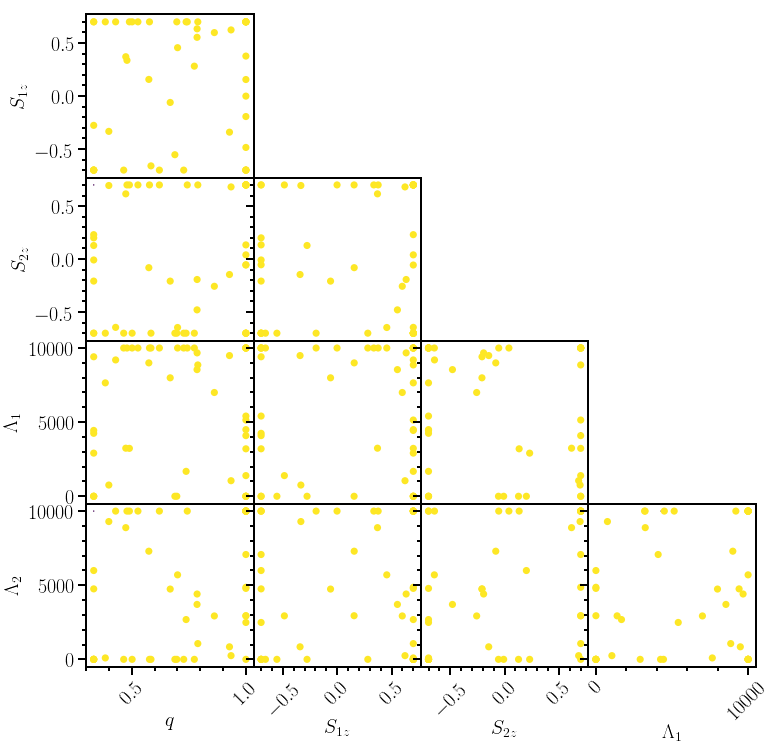

In [232]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = points_new
error = np.ones(len(params))
error[0]*=0.5
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, figsize=(10, 10))

In [233]:
np.savetxt('../data/newpoints.txt', points_new)